<a href="https://colab.research.google.com/github/ThierrryScotto/Time-Series-Forecasting-Atmospheric-CO2/blob/main/time_series_forecasting_atmospheric_co2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing the libraries**

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import datetime

from scipy.stats import sem
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.SARIMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [3]:
!pip install skforecast
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 5.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 KB 5.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for o

In [4]:
from xgboost import XGBRegressor
from prophet import Prophet

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# **Getting Data**

Dataset: [Mauna Loa Weekly Atmospheric CO2 Data](https://www.statsmodels.org/dev/datasets/generated/co2.html)

In [6]:
dataset = sm.datasets.co2.load_pandas().data

# **Data Preparation**

In [7]:
dataset.columns

Index(['co2'], dtype='object')

In [8]:
dataset.shape

(2284, 1)

In [9]:
dataset.head(5)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [10]:
dataset.describe()

,co2
count,2225.000000
mean,340.142247
std,17.003885
min,313.000000
25%,324.800000
50%,338.300000
75%,354.800000
max,373.900000


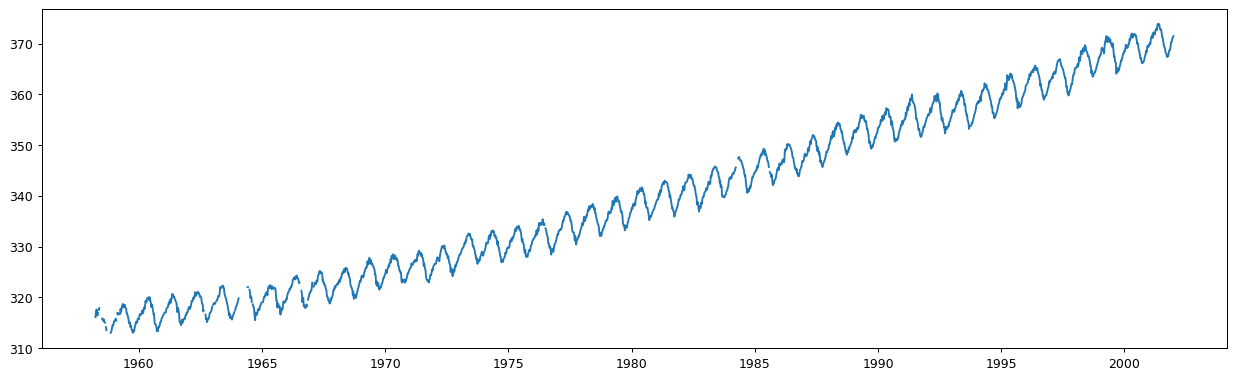

In [11]:
plt.figure(figsize=(17, 5), dpi=90)
plt.plot(dataset.index, dataset['co2'])

In [12]:
dataset.index.min(), dataset.index.max()

(Timestamp('1958-03-29 00:00:00', freq='W-SAT'),
 Timestamp('2001-12-29 00:00:00', freq='W-SAT'))

#### SE (Standard Error)

In [13]:
sem(np.array(dataset['co2']))

nan

## Checking null values

In [14]:
dataset['co2'].isnull().sum()

59

In [15]:
dataset[dataset['co2'].isnull() == True]['co2']

1958-05-10   NaN
1958-05-31   NaN
1958-06-07   NaN
1958-06-14   NaN
1958-06-21   NaN
1958-06-28   NaN
1958-08-23   NaN
1958-09-13   NaN
1958-09-20   NaN
1958-09-27   NaN
1958-10-04   NaN
1958-10-11   NaN
1958-10-18   NaN
1958-10-25   NaN
1958-11-01   NaN
1959-02-07   NaN
1959-03-14   NaN
1959-05-30   NaN
1959-08-15   NaN
1962-08-25   NaN
1962-09-01   NaN
1962-09-08   NaN
1962-12-29   NaN
1963-02-16   NaN
1963-05-04   NaN
1963-11-23   NaN
1964-01-25   NaN
1964-02-01   NaN
1964-02-08   NaN
1964-02-15   NaN
1964-02-22   NaN
1964-02-29   NaN
1964-03-07   NaN
1964-03-14   NaN
1964-03-21   NaN
1964-03-28   NaN
1964-04-04   NaN
1964-04-11   NaN
1964-04-18   NaN
1964-04-25   NaN
1964-05-02   NaN
1964-05-09   NaN
1964-05-16   NaN
1964-05-23   NaN
1964-06-13   NaN
1964-06-20   NaN
1964-08-08   NaN
1966-07-16   NaN
1966-07-23   NaN
1966-07-30   NaN
1966-11-05   NaN
1967-01-21   NaN
1967-01-28   NaN
1976-06-26   NaN
1984-03-31   NaN
1984-04-07   NaN
1984-04-14   NaN
1984-04-21   NaN
1985-08-03   N

### **Interpolation**

In [16]:
def plot_interpolation(df_one, df_two, legend_one, legend_two, x_label, y_label, title, figsize=(12,10), dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.scatter(df_one.index, df_one['co2'])
  plt.plot(df_two.index, df_two['co2'], 'red')
  plt.legend([legend_one, legend_two])
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [17]:
def plot_dataset_scatter(x, y, x_label, y_label, title, figsize=(12,10), dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.scatter(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

#### Linear

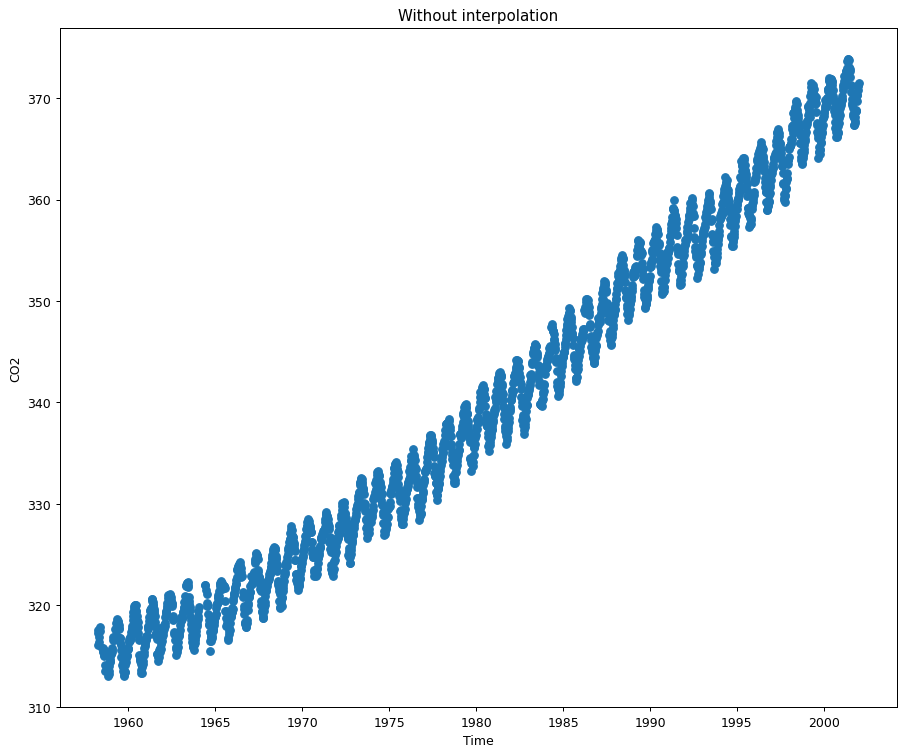

In [18]:
plot_dataset_scatter(dataset.index, dataset['co2'], 'Time', 'CO2', "Without interpolation")

In [19]:
dataset_origin = dataset.copy()
dataset_linear_interpolation = dataset.interpolate(method="linear")

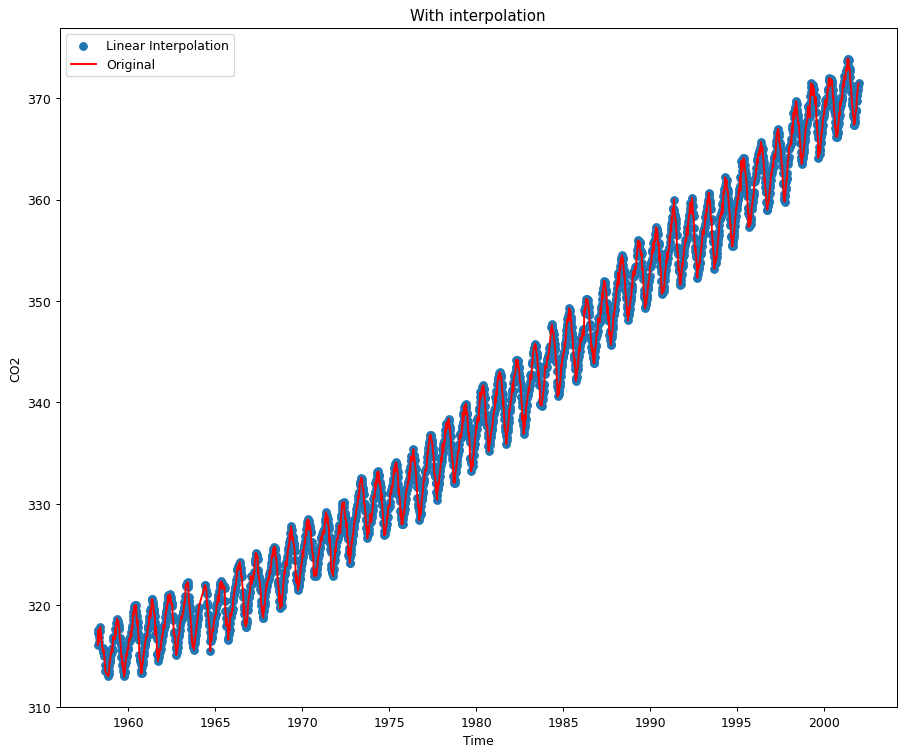

In [20]:
plot_interpolation(dataset_origin, dataset_linear_interpolation, "Linear Interpolation", "Original", 
                   "Time", "CO2", "With interpolation")

#### Polynomial

In [21]:
polynomial_interpolate = dataset.interpolate(method="polynomial", order=3)

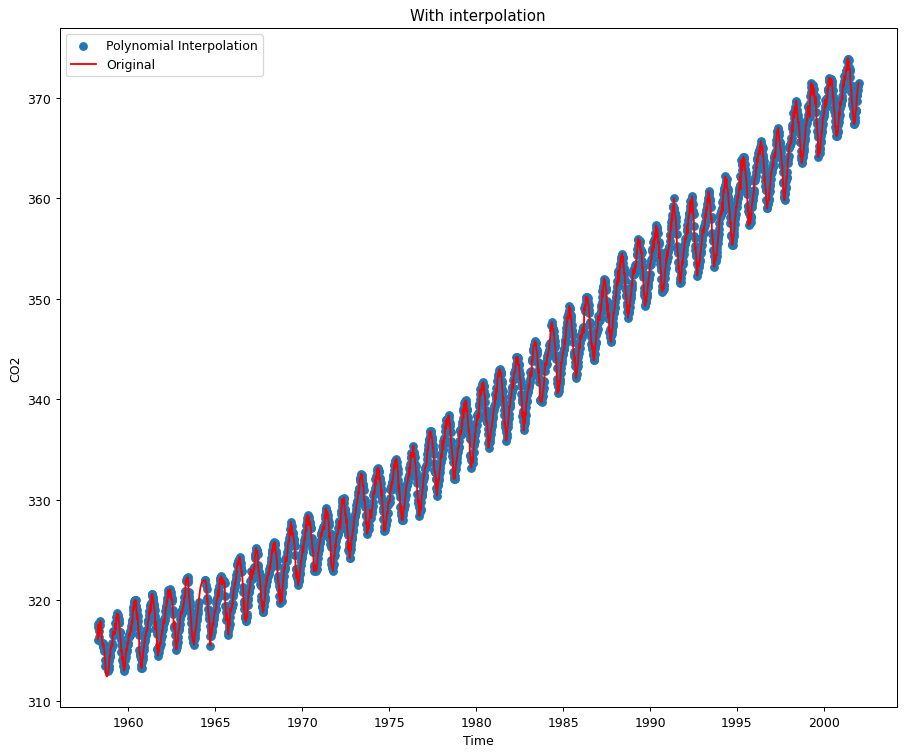

In [22]:
plot_interpolation(dataset_origin, polynomial_interpolate, "Polynomial Interpolation", "Original", 
                   "Time", "CO2", "With interpolation")

#### Applying Polynomial Interpolation

In [23]:
dataset['co2'] = dataset.interpolate(method="polynomial", order=3)

In [24]:
dataset['co2']

1958-03-29    316.1
1958-04-05    317.3
1958-04-12    317.6
1958-04-19    317.5
1958-04-26    316.4
              ...  
2001-12-01    370.3
2001-12-08    370.8
2001-12-15    371.2
2001-12-22    371.3
2001-12-29    371.5
Freq: W-SAT, Name: co2, Length: 2284, dtype: float64

In [25]:
dataset['co2'].isnull().sum()

0

#### Calculating SE, after filling empty data

In [26]:
sem(np.array(dataset['co2']))

0.35779713136452984

# **Time Series analysis**

## Finding out if my series is stationary

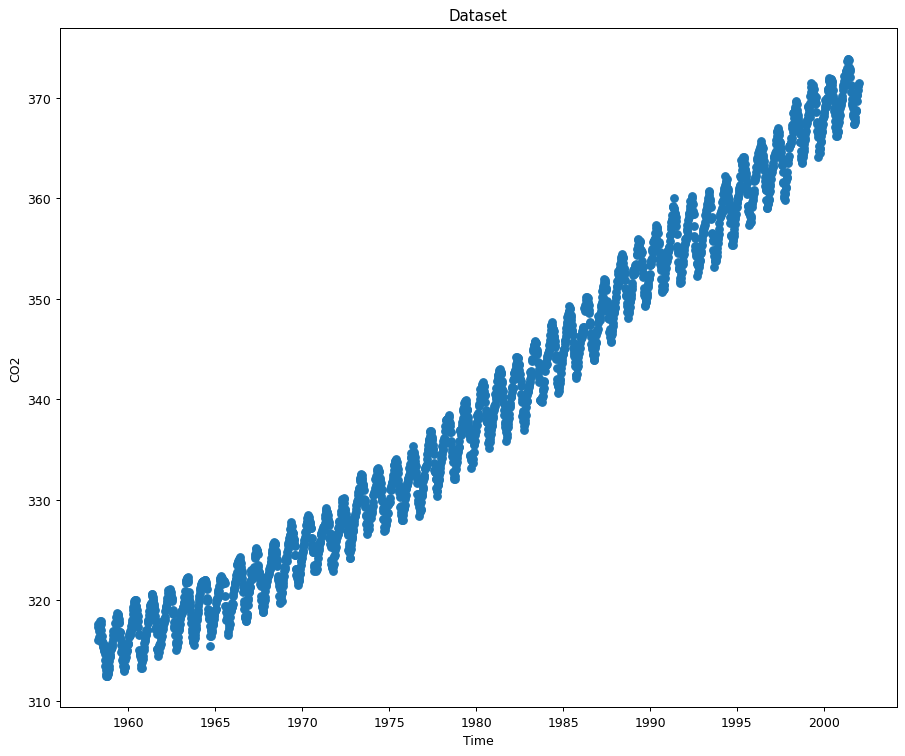

In [27]:
plot_dataset_scatter(dataset.index, dataset['co2'], 'Time', 'CO2', "Dataset")

### Separating the time series into two groups and calculating the mean and variance of each.

In [28]:
def mean_variance(df):
  middle =  int(len(df) / 2)

  part_1, part_2 = df.head(middle), df.tail(middle)
  mean1, mean2 = part_1.mean(), part_2.mean()
  var1, var2 = part_1.var(), part_2.var()
  print('\n-- MEAN and VARIANCE --')
  print('Average of set 1: %f, Average of set 1: %f' % (mean1, mean2))
  print('variance of set 1: %f, Variance of set 2: %f\n' % (var1, var2))

In [29]:
mean_variance(dataset)


-- MEAN and VARIANCE --
Average of set 1: 324.818411, Average of set 1: 354.495623
variance of set 1: 45.650350, Variance of set 2: 98.641338



### Checking if Gaussian distribution makes sense

array([[<Axes: title={'center': 'co2'}>]], dtype=object)

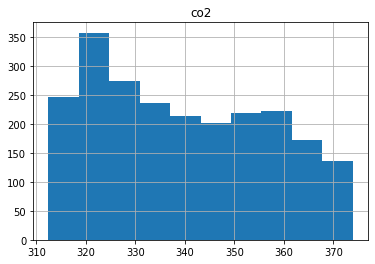

In [30]:
dataset.hist()

### Checking autocorrelation

In [31]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")

**Dickey–Fuller test**<p>

In [32]:
def check_stationarity(df):
  result = adfuller(df)

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
print('\n\n')

We have a Null Hypothesis (H0), so we are sure that our series is not stationary.

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

In [33]:
check_stationarity(dataset['co2'])

-- Dickey–Fuller test --
ADF Statistic: -0.039010
p-value: 0.955185
Critical values: 
	1%: -3.433252
	5%: -2.862822
	10%: -2.567452


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

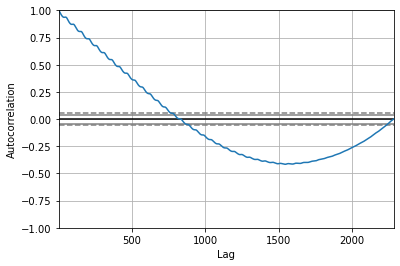

In [34]:
pd.plotting.autocorrelation_plot(dataset['co2'])

**Using ACF and PACF**

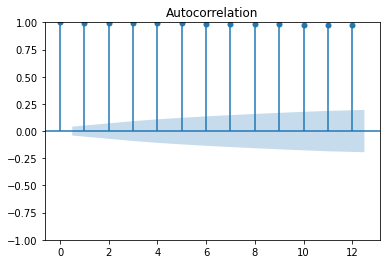

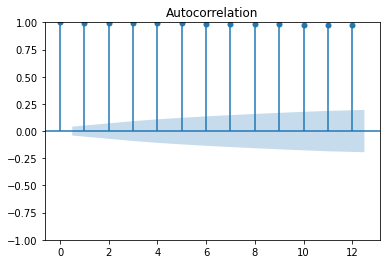

In [35]:
plot_acf(dataset, lags=12)

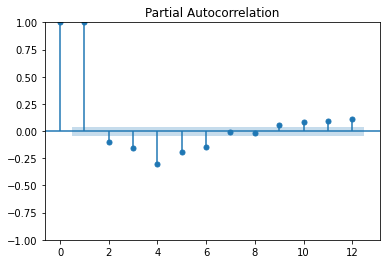

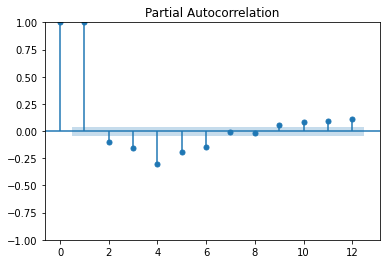

In [36]:
plot_pacf(dataset, lags=12, method="ols")

## Converting series to stationary

In [37]:
def plot_dataset(x, y, x_label, y_label, title, figsize=(15, 5), dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

#### Taking the square root of the data

In [38]:
dataset_sqrt = np.sqrt(dataset['co2'])
dataset_diff = dataset_sqrt.diff().dropna()
dataset_diff

1958-04-05    0.033715
1958-04-12    0.008419
1958-04-19   -0.002806
1958-04-26   -0.030894
1958-05-03    0.014049
                ...   
2001-12-01    0.000000
2001-12-08    0.012987
2001-12-15    0.010383
2001-12-22    0.002595
2001-12-29    0.005189
Freq: W-SAT, Name: co2, Length: 2283, dtype: float64

-- Dickey–Fuller test --
ADF Statistic: -15.621137
p-value: 0.000000
Critical values: 
	1%: -3.433253
	5%: -2.862823
	10%: -2.567453

-- MEAN and VARIANCE --
Average of set 1: 0.000533, Average of set 1: 0.000765
variance of set 1: 0.000168, Variance of set 2: 0.000184



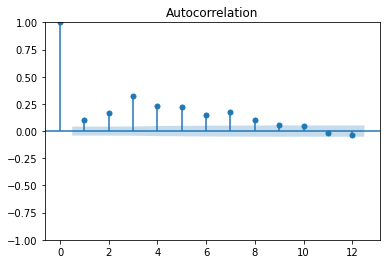

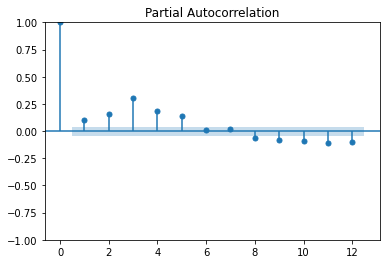

In [39]:
plot_autocorrelation(dataset_diff, lags=12)
check_stationarity(dataset_diff)
mean_variance(dataset_diff)

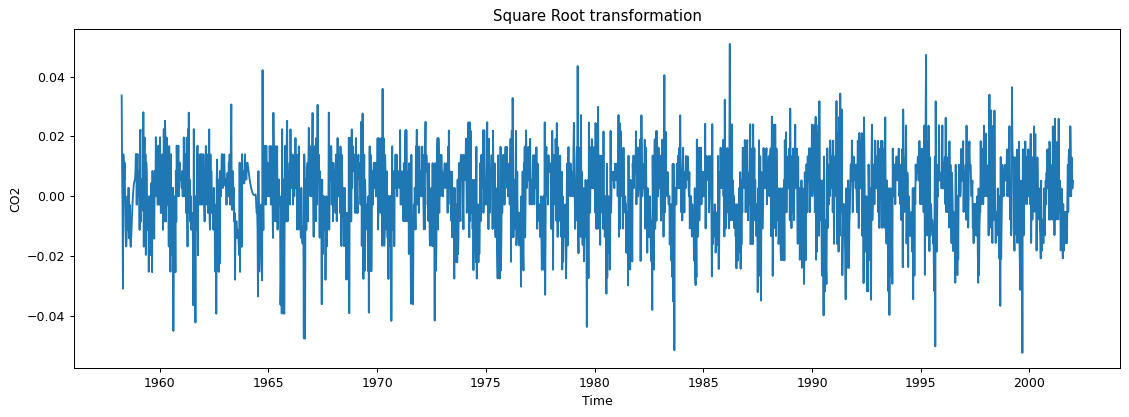

In [40]:
plot_dataset(dataset_diff.index, dataset_diff, 'Time', 'CO2', "Square Root transformation")

#### Log transforming of the data

In [41]:
dataset_log = np.log(dataset['co2'])
dataset_log = dataset_log.diff().dropna()
dataset_log

1958-04-05    0.003789
1958-04-12    0.000945
1958-04-19   -0.000315
1958-04-26   -0.003471
1958-05-03    0.001579
                ...   
2001-12-01    0.000000
2001-12-08    0.001349
2001-12-15    0.001078
2001-12-22    0.000269
2001-12-29    0.000539
Freq: W-SAT, Name: co2, Length: 2283, dtype: float64

<Axes: >

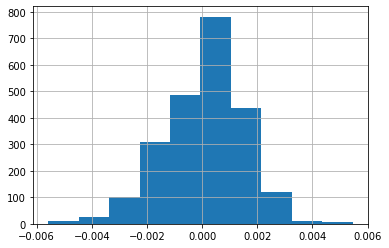

In [42]:
dataset_log.hist()

-- Dickey–Fuller test --
ADF Statistic: -15.616596
p-value: 0.000000
Critical values: 
	1%: -3.433253
	5%: -2.862823
	10%: -2.567453

-- MEAN and VARIANCE --
Average of set 1: 0.000059, Average of set 1: 0.000081
variance of set 1: 0.000002, Variance of set 2: 0.000002



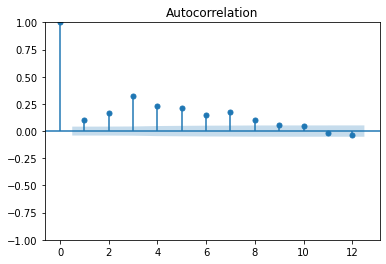

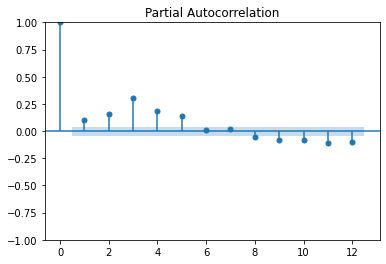

In [43]:
plot_autocorrelation(dataset_log, lags=12)
check_stationarity(dataset_log)
mean_variance(dataset_log)

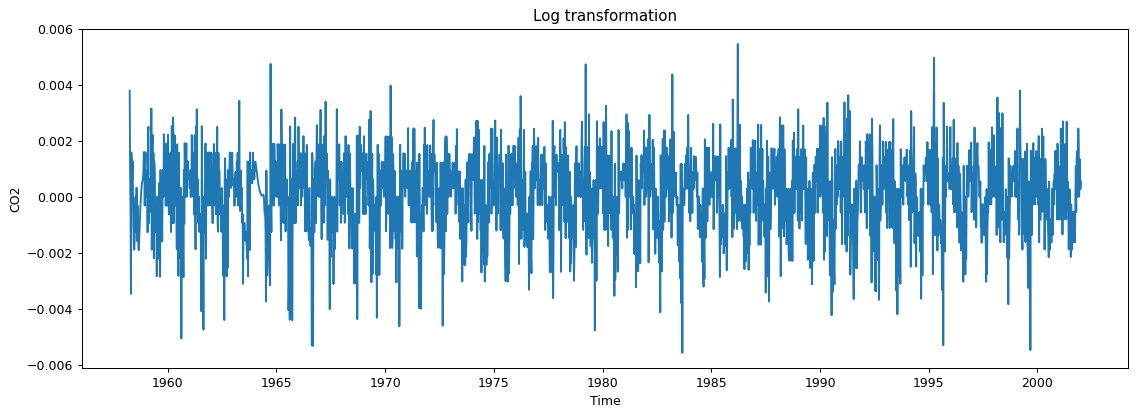

In [44]:
plot_dataset(dataset_log.index, dataset_log, 'Time', 'CO2', "Log transformation")

#### Taking the cube root

In [45]:
dataset_cbrt = np.cbrt(dataset['co2'])
dataset_cbrt = dataset_cbrt.diff().dropna()
dataset_cbrt

1958-04-05    0.008609
1958-04-12    0.002149
1958-04-19   -0.000716
1958-04-26   -0.007888
1958-05-03    0.003588
                ...   
2001-12-01    0.000000
2001-12-08    0.003231
2001-12-15    0.002582
2001-12-22    0.000645
2001-12-29    0.001290
Freq: W-SAT, Name: co2, Length: 2283, dtype: float64

-- Dickey–Fuller test --
ADF Statistic: -15.619796
p-value: 0.000000
Critical values: 
	1%: -3.433253
	5%: -2.862823
	10%: -2.567453

-- MEAN and VARIANCE --
Average of set 1: 0.000135, Average of set 1: 0.000192
variance of set 1: 0.000011, Variance of set 2: 0.000012



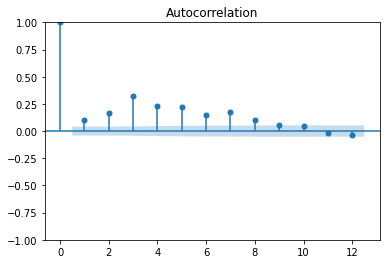

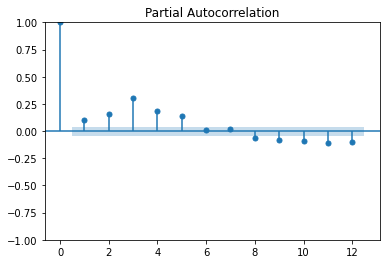

In [46]:
plot_autocorrelation(dataset_cbrt, lags=12)
check_stationarity(dataset_cbrt)
mean_variance(dataset_cbrt)

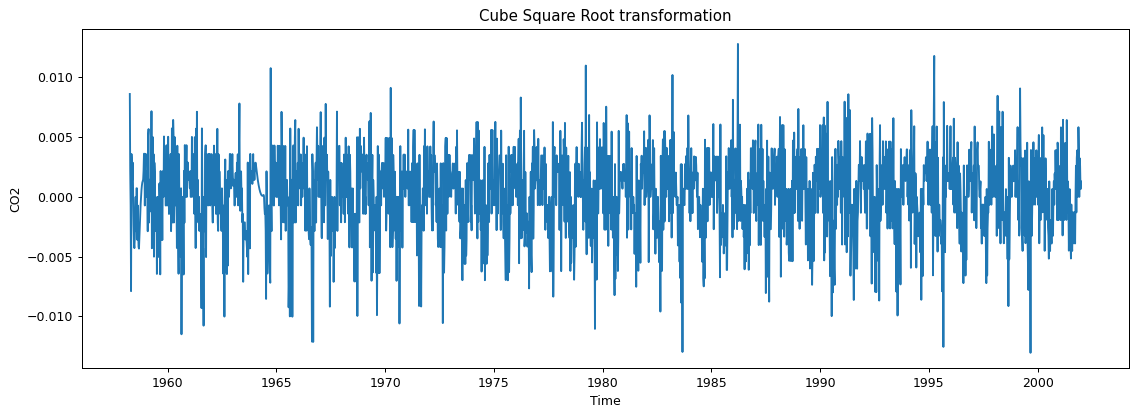

In [47]:
plot_dataset(dataset_cbrt.index, dataset_cbrt, 'Time', 'CO2', "Cube Square Root transformation")

#### Using the difference

In [48]:
dataset_diference = dataset['co2'] - dataset['co2'].shift(1)
dataset_diference = dataset_diference.dropna()
dataset_diference

1958-04-05    1.2
1958-04-12    0.3
1958-04-19   -0.1
1958-04-26   -1.1
1958-05-03    0.5
             ... 
2001-12-01    0.0
2001-12-08    0.5
2001-12-15    0.4
2001-12-22    0.1
2001-12-29    0.2
Freq: W-SAT, Name: co2, Length: 2283, dtype: float64

-- Dickey–Fuller test --
ADF Statistic: -15.624098
p-value: 0.000000
Critical values: 
	1%: -3.433253
	5%: -2.862823
	10%: -2.567453

-- MEAN and VARIANCE --
Average of set 1: 0.019281, Average of set 1: 0.028834
variance of set 1: 0.218861, Variance of set 2: 0.260288



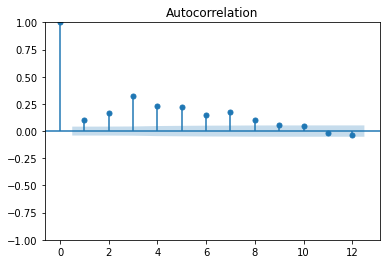

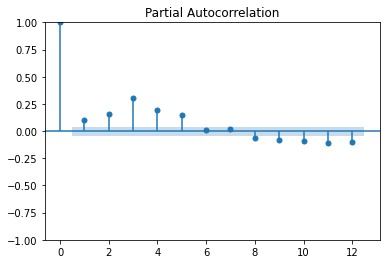

In [49]:
plot_autocorrelation(dataset_diference, lags=12)
check_stationarity(dataset_diference)
mean_variance(dataset_diference)

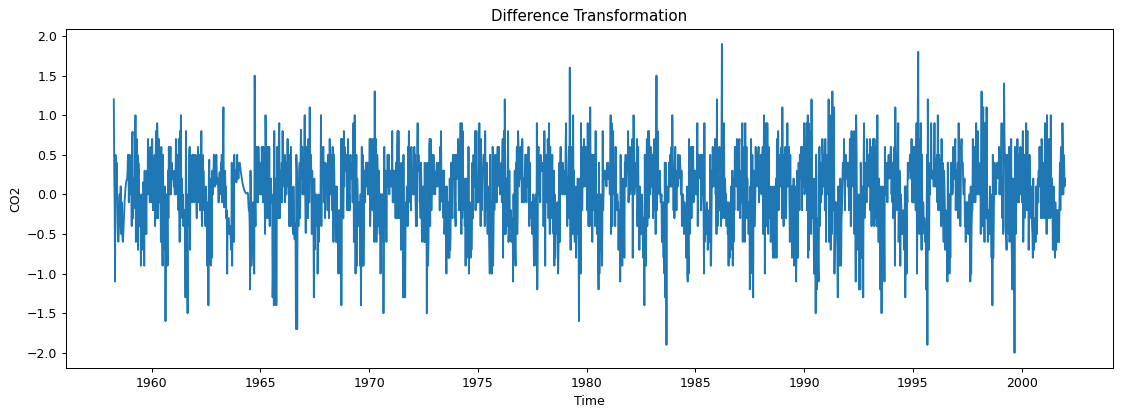

In [50]:
plot_dataset(dataset_diference.index, dataset_diference, 'Time', 'CO2', "Difference Transformation")

#### Seasonal Differencing

In [51]:
n = 7
dataset_seasonal_diference = dataset['co2'] - dataset['co2'].shift(n)
dataset_seasonal_diference = dataset_seasonal_diference.dropna()
dataset_seasonal_diference

1958-05-17    1.400000
1958-05-24    0.600000
1958-05-31    0.350365
1958-06-07    0.116975
1958-06-14    0.667538
                ...   
2001-12-01    2.700000
2001-12-08    2.700000
2001-12-15    2.500000
2001-12-22    2.600000
2001-12-29    2.700000
Freq: W-SAT, Name: co2, Length: 2277, dtype: float64

-- Dickey–Fuller test --
ADF Statistic: -23.592753
p-value: 0.000000
Critical values: 
	1%: -3.433261
	5%: -2.862826
	10%: -2.567455

-- MEAN and VARIANCE --
Average of set 1: 0.131633, Average of set 1: 0.197715
variance of set 1: 3.173921, Variance of set 2: 3.990901



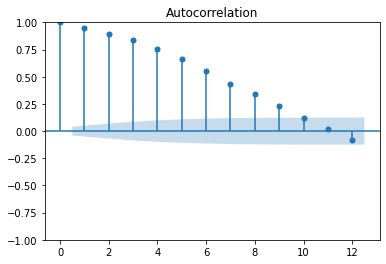

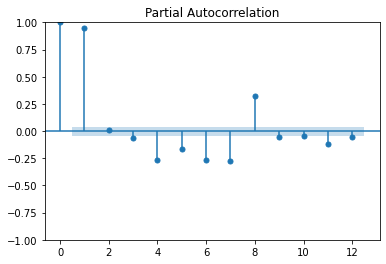

In [52]:
plot_autocorrelation(dataset_seasonal_diference, lags=12)
check_stationarity(dataset_seasonal_diference)
mean_variance(dataset_seasonal_diference)

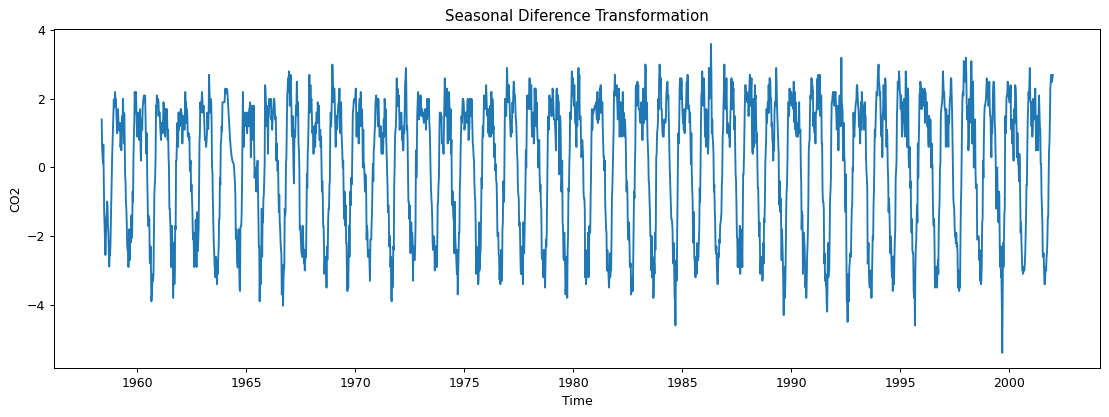

In [53]:
plot_dataset(dataset_seasonal_diference.index, dataset_seasonal_diference, 'Time', 'CO2', "Seasonal Diference Transformation")

## Training the model

#### STL Decomposition

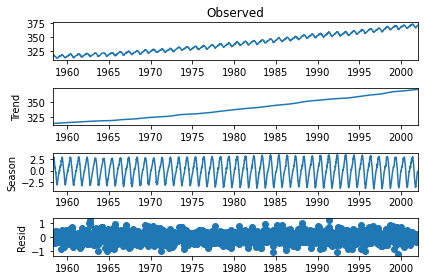

In [66]:
decomp = STL(dataset).fit()

decomp.plot()
plt.show()

In [67]:
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

##### Trend

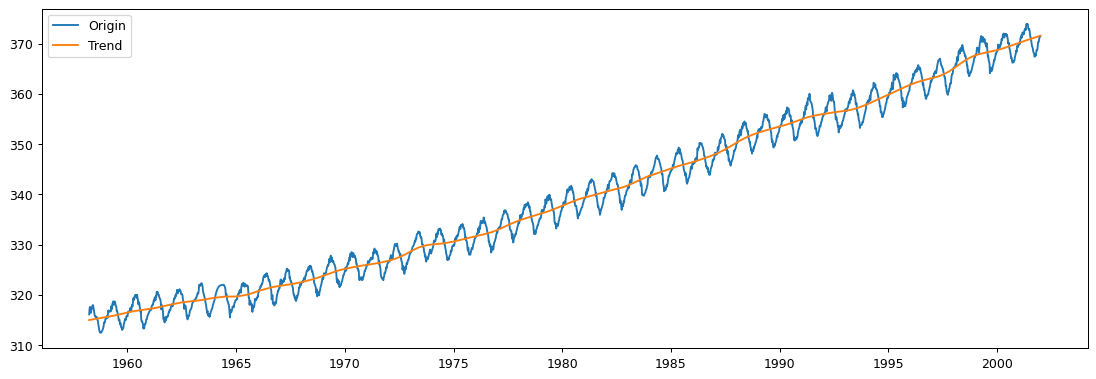

In [68]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=90)
ax.plot(dataset.index, dataset['co2'], label="Origin")
ax.plot(dataset.index, trend, label="Trend")
ax.legend()

##### De-trended

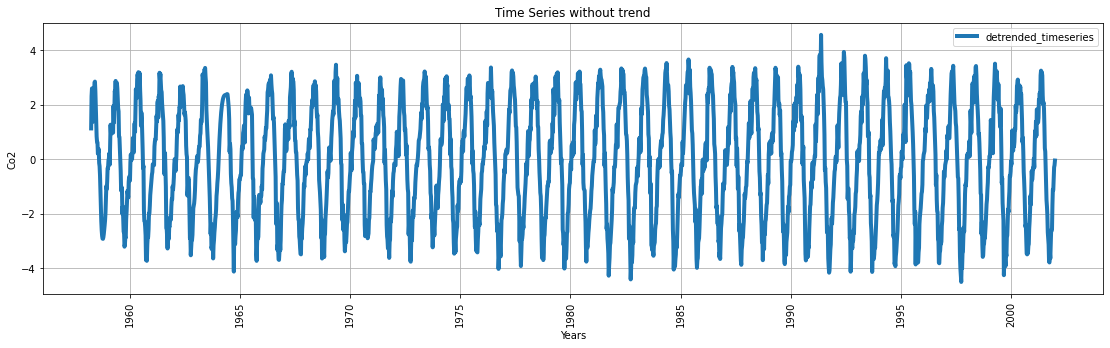

In [69]:
dataset_de_trended = dataset['co2'] - trend

plt.figure(figsize=(19,5))
plt.grid()
plt.plot(dataset.index, dataset_de_trended, marker='', linestyle='-', label='detrended_timeseries', linewidth=4)
plt.title("Time Series without trend")
plt.xlabel("Years")
plt.ylabel("Co2")
plt.xticks(rotation=90)
plt.legend()
plt.show()

##### De-seasonalised

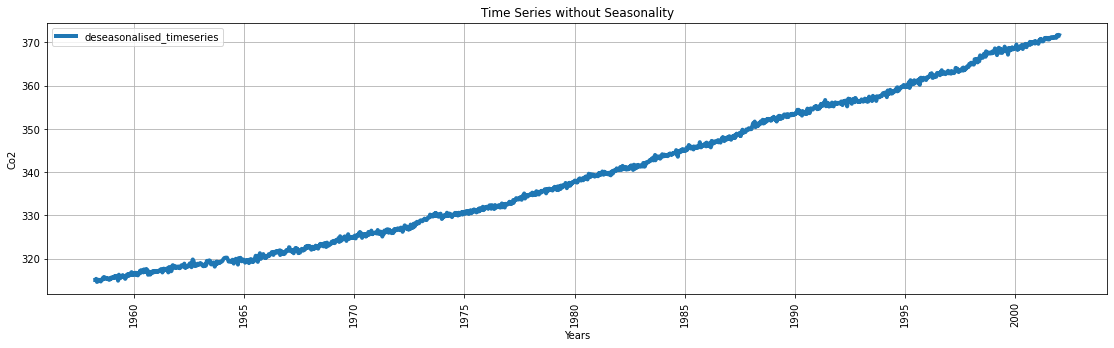

In [70]:
dataset_de_seasonalised = dataset['co2'] - seasonal

plt.figure(figsize=(19,5))
plt.grid()
plt.plot(dataset.index, dataset_de_seasonalised, marker='', linestyle='-', label='deseasonalised_timeseries', linewidth=4)
plt.title("Time Series without Seasonality")
plt.xlabel("Years")
plt.ylabel("Co2")
plt.xticks(rotation=90)
plt.legend()
plt.show()

##### Residual

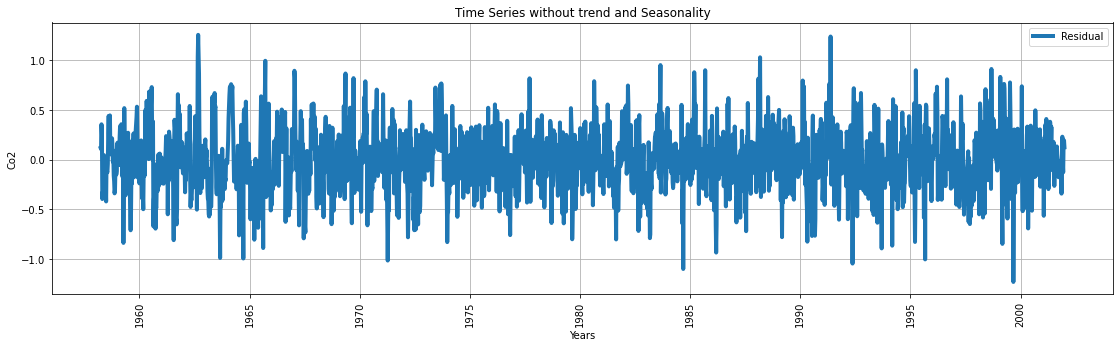

In [71]:
dataset_residuals = dataset['co2'] - trend - seasonal

plt.figure(figsize=(19,5))
plt.grid()
plt.plot(dataset.index, dataset_residuals, marker='', linestyle='-', label='Residual', linewidth=4)
plt.title("Time Series without trend and Seasonality")
plt.xlabel("Years")
plt.ylabel("Co2")
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### Split data

In [54]:
data = pd.Series(dataset_diference)

end_train      = "1993-04-03"
end_validation = "1997-08-16"

In [55]:
# data_train = data.loc[: end_train, :]
data_train = data.loc[:end_train]
data_val   = data.loc[end_train:end_validation]
data_test  = data.loc[end_validation:,]
data_total = data.loc[: end_validation]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
print(f"Dates total      : {data_total.index.min()} --- {data_total.index.max()}  (n={len(data_total)})")

Dates train      : 1958-04-05 00:00:00 --- 1993-04-03 00:00:00  (n=1827)
Dates validacion : 1993-04-03 00:00:00 --- 1997-08-16 00:00:00  (n=229)
Dates test       : 1997-08-16 00:00:00 --- 2001-12-29 00:00:00  (n=229)
Dates total      : 1958-04-05 00:00:00 --- 1997-08-16 00:00:00  (n=2055)


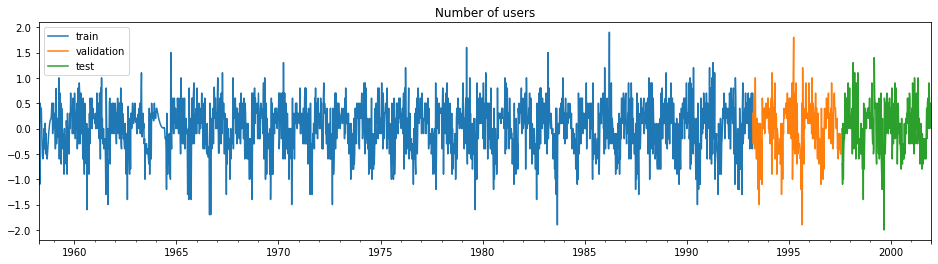

In [56]:
fig, ax = plt.subplots(figsize=(16, 4))
data_train.plot(ax=ax, label='train')
data_val.plot(ax=ax, label='validation')
data_test.plot(ax=ax, label='test')
ax.set_title('Number of users')
ax.legend();

#### SARIMA

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

16


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 7, dataset_diference)
result_df

<ipython-input-125-1c6b5188e689>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)x(P,Q)",AIC
0,"(1, 1, 1, 1)",3048.870613
1,"(1, 1, 0, 1)",3058.066956
2,"(0, 1, 1, 1)",3123.415250
3,"(0, 1, 0, 1)",3136.472760
4,"(1, 0, 1, 1)",3817.457622
5,"(1, 0, 0, 1)",3820.500601
6,"(1, 1, 1, 0)",3934.912648
7,"(0, 1, 1, 0)",3996.094058
8,"(0, 1, 0, 0)",4355.538174
9,"(1, 1, 0, 0)",4403.250674


In [ ]:
best_model = SARIMAX(dataset_diference, order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(


                                     SARIMAX Results                                     
Dep. Variable:                               co2   No. Observations:                 2283
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood               -1483.578
Date:                           Tue, 21 Mar 2023   AIC                           2977.155
Time:                                   00:57:40   BIC                           3005.811
Sample:                               04-05-1958   HQIC                          2987.608
                                    - 12-29-2001                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0632      0.019    -57.408      0.000      -1.099      -1.027
ma.L2          0.3049      0.019     16.153

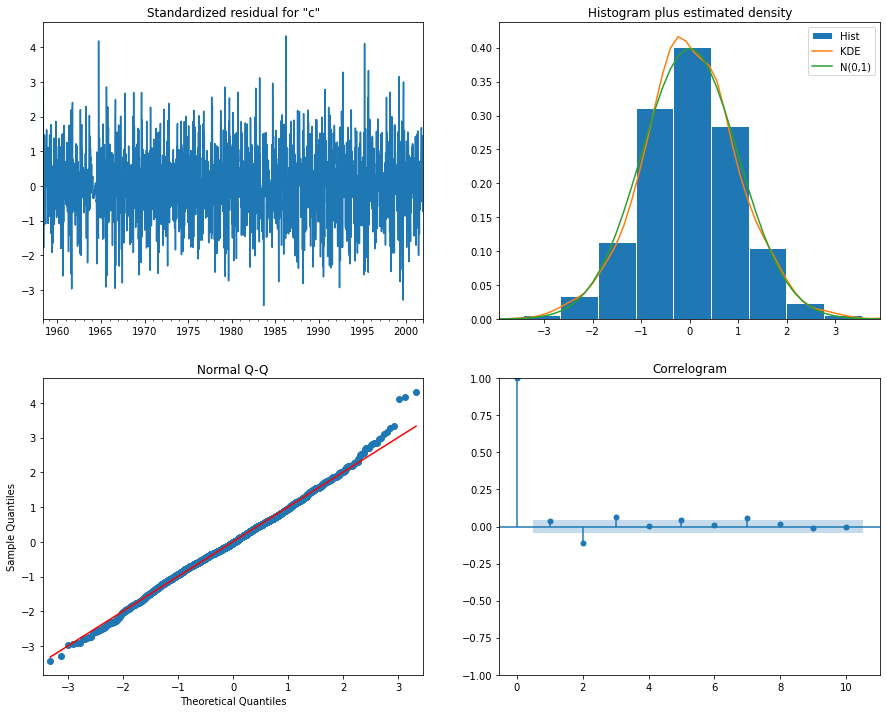

In [ ]:
best_model.plot_diagnostics(figsize=(15,12));

In [ ]:
fitted_values = best_model.fittedvalues

In [ ]:
n_periods = 14
forecast = best_model.predict(n_periods=n_periods, return_conf_int=True)

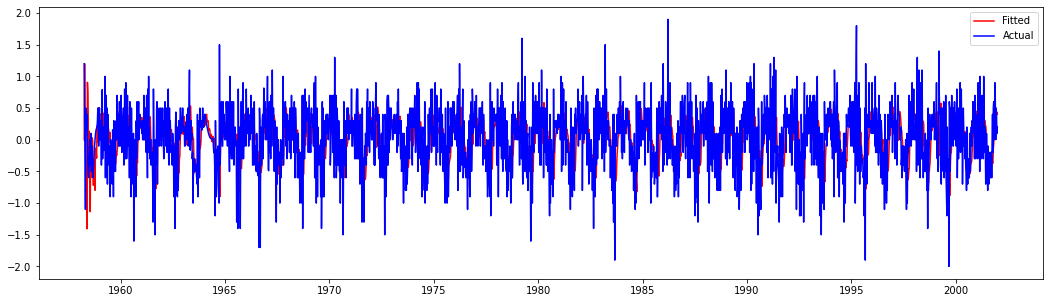

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(fitted_values, color='r', label='Fitted')
plt.plot(dataset_diference, color='b', label='Actual')
plt.legend()
plt.show()

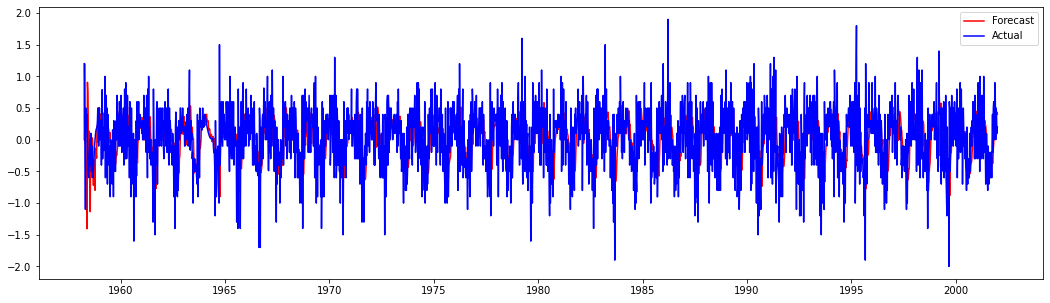

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(forecast, color='r', label='Forecast')
plt.plot(dataset_diference, color='b', label='Actual')
plt.legend()
plt.show()

### Prophet

In [72]:
df_test = pd.DataFrame(data_test)
df_train = pd.DataFrame(data_train)
df_total = pd.DataFrame(data_total)

In [73]:
ts = pd.DataFrame({'ds': df_total.index, 'y': df_total['co2']})

In [74]:
prophet = Prophet()
prophet.fit(ts)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


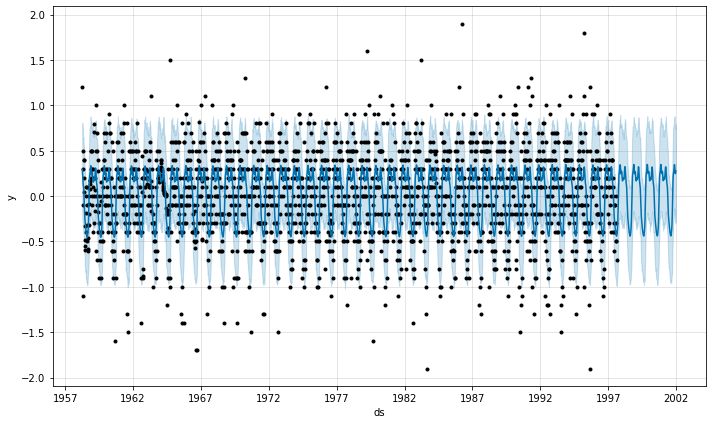

In [75]:
future   = prophet.make_future_dataframe(periods=len(df_test), freq='W', include_history=True)
forecast = prophet.predict(future)

prophet.plot(forecast)
plt.show()

Text(0.5, 1.0, 'Forecast Prothet')

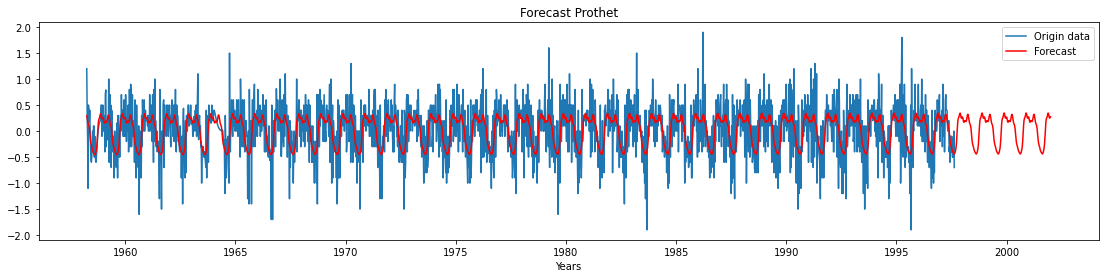

In [76]:
plt.figure(figsize=(19, 4))
plt.plot(df_total.index, df_total)
plt.plot(forecast['ds'], forecast['yhat'], 'red')
plt.legend(["Origin data", "Forecast"])
plt.xlabel("Years")
plt.title("Forecast Prothet")

Text(0.5, 1.0, 'Forecast Prothet - Test')

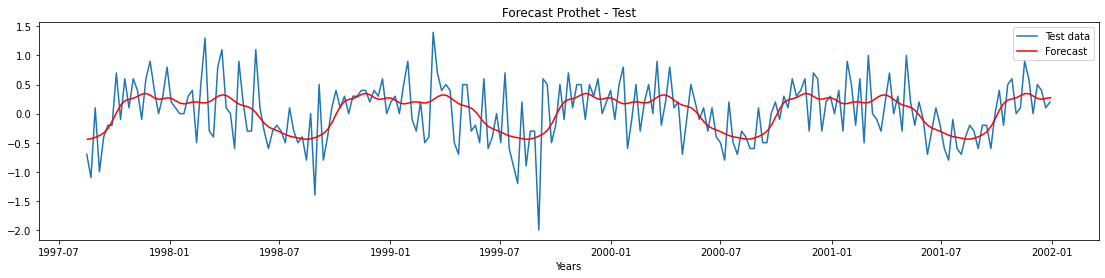

In [77]:
forecast_test = forecast.iloc[-len(df_test):]

plt.figure(figsize=(19, 4))
plt.plot(df_test.index, df_test['co2'])
plt.plot(forecast_test['ds'], forecast_test['yhat'], 'red')
plt.legend(["Test data", "Forecast"])
plt.xlabel("Years")
plt.title("Forecast Prothet - Test")

In [78]:
print(f"RMSE: {mean_squared_error(df_test, forecast_test['yhat'])}")

RMSE: 0.17257432627103714


### XGBoost

#### Create forecaster

In [ ]:
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(random_state=123),
    lags = 24
)
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous 

#### Grid search of Hyperparameter tuning (tuning)

In [ ]:
# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_deep': [1, 2, 3, 5, 10],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Lags used as predictors
lags_grid = [4, 12, 18, 24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data_total, # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 252.


loop param_grid:   0%|                                             | 0/36 [00:00<?, ?it/s]

[01:17:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   3%|█                                    | 1/36 [00:00<00:10,  3.40it/s]

[01:17:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   6%|██                                   | 2/36 [00:00<00:12,  2.81it/s]

[01:17:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   8%|███                                  | 3/36 [00:01<00:20,  1.63it/s]

[01:17:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  11%|████                                 | 4/36 [00:01<00:15,  2.01it/s]

[01:17:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  14%|█████▏                               | 5/36 [00:02<00:14,  2.18it/s]

[01:17:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  17%|██████▏                              | 6/36 [00:03<00:18,  1.63it/s]

[01:17:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  19%|███████▏                             | 7/36 [00:03<00:15,  1.92it/s]

[01:17:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  22%|████████▏                            | 8/36 [00:03<00:13,  2.12it/s]

[01:17:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  25%|█████████▎                           | 9/36 [00:04<00:16,  1.65it/s]

[01:17:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  28%|██████████                          | 10/36 [00:05<00:13,  1.96it/s]

[01:17:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  31%|███████████                         | 11/36 [00:05<00:11,  2.12it/s]

[01:17:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  33%|████████████                        | 12/36 [00:06<00:14,  1.62it/s]

[01:17:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  36%|█████████████                       | 13/36 [00:06<00:11,  1.94it/s]

[01:17:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  39%|██████████████                      | 14/36 [00:07<00:10,  2.13it/s]

[01:17:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  42%|███████████████                     | 15/36 [00:08<00:12,  1.65it/s]

[01:17:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  44%|████████████████                    | 16/36 [00:08<00:10,  1.98it/s]

[01:17:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  47%|█████████████████                   | 17/36 [00:12<00:29,  1.55s/it]

[01:17:58] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  50%|██████████████████                  | 18/36 [00:13<00:25,  1.42s/it]

[01:17:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  53%|███████████████████                 | 19/36 [00:13<00:18,  1.08s/it]

[01:17:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  56%|████████████████████                | 20/36 [00:14<00:13,  1.15it/s]

[01:17:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  58%|█████████████████████               | 21/36 [00:14<00:13,  1.15it/s]

[01:18:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  61%|██████████████████████              | 22/36 [00:15<00:09,  1.42it/s]

[01:18:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  64%|███████████████████████             | 23/36 [00:15<00:07,  1.67it/s]

[01:18:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  67%|████████████████████████            | 24/36 [00:16<00:08,  1.43it/s]

[01:18:02] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  69%|█████████████████████████           | 25/36 [00:16<00:06,  1.75it/s]

[01:18:02] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  72%|██████████████████████████          | 26/36 [00:17<00:04,  2.00it/s]

[01:18:02] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  75%|███████████████████████████         | 27/36 [00:18<00:05,  1.62it/s]

[01:18:03] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  78%|████████████████████████████        | 28/36 [00:18<00:04,  1.90it/s]

[01:18:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  81%|█████████████████████████████       | 29/36 [00:18<00:03,  2.12it/s]

[01:18:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  83%|██████████████████████████████      | 30/36 [00:19<00:03,  1.71it/s]

[01:18:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  86%|███████████████████████████████     | 31/36 [00:19<00:02,  2.02it/s]

[01:18:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  89%|████████████████████████████████    | 32/36 [00:20<00:01,  2.19it/s]

[01:18:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  92%|█████████████████████████████████   | 33/36 [00:21<00:01,  1.73it/s]

[01:18:06] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  94%|██████████████████████████████████  | 34/36 [00:21<00:00,  2.03it/s]

[01:18:07] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  97%|███████████████████████████████████ | 35/36 [00:21<00:00,  2.11it/s]

[01:18:07] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   0%|                                             | 0/36 [00:00<?, ?it/s]

[01:18:08] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   3%|█                                    | 1/36 [00:03<02:14,  3.85s/it]

[01:18:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   6%|██                                   | 2/36 [00:04<01:03,  1.87s/it]

[01:18:13] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   8%|███                                  | 3/36 [00:05<00:56,  1.72s/it]

[01:18:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  11%|████                                 | 4/36 [00:06<00:37,  1.17s/it]

[01:18:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  14%|█████▏                               | 5/36 [00:06<00:28,  1.08it/s]

[01:18:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  17%|██████▏                              | 6/36 [00:08<00:33,  1.12s/it]

[01:18:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  19%|███████▏                             | 7/36 [00:08<00:25,  1.15it/s]

[01:18:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  22%|████████▏                            | 8/36 [00:09<00:21,  1.31it/s]

[01:18:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  25%|█████████▎                           | 9/36 [00:10<00:26,  1.00it/s]

[01:18:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  28%|██████████                          | 10/36 [00:10<00:20,  1.25it/s]

[01:18:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  31%|███████████                         | 11/36 [00:11<00:17,  1.43it/s]

[01:18:20] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  33%|████████████                        | 12/36 [00:13<00:23,  1.03it/s]

[01:18:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  36%|█████████████                       | 13/36 [00:13<00:17,  1.29it/s]

[01:18:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  39%|██████████████                      | 14/36 [00:14<00:16,  1.35it/s]

[01:18:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  42%|███████████████                     | 15/36 [00:19<00:47,  2.25s/it]

[01:18:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  44%|████████████████                    | 16/36 [00:20<00:34,  1.70s/it]

[01:18:29] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  47%|█████████████████                   | 17/36 [00:20<00:25,  1.34s/it]

[01:18:29] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  50%|██████████████████                  | 18/36 [00:22<00:24,  1.37s/it]

[01:18:30] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  53%|███████████████████                 | 19/36 [00:22<00:18,  1.07s/it]

[01:18:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  56%|████████████████████                | 20/36 [00:23<00:14,  1.10it/s]

[01:18:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  58%|█████████████████████               | 21/36 [00:24<00:16,  1.07s/it]

[01:18:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  61%|██████████████████████              | 22/36 [00:24<00:11,  1.17it/s]

[01:18:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  64%|███████████████████████             | 23/36 [00:25<00:09,  1.34it/s]

[01:18:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  67%|████████████████████████            | 24/36 [00:26<00:11,  1.05it/s]

[01:18:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  69%|█████████████████████████           | 25/36 [00:27<00:08,  1.29it/s]

[01:18:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  72%|██████████████████████████          | 26/36 [00:27<00:06,  1.47it/s]

[01:18:36] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  75%|███████████████████████████         | 27/36 [00:32<00:18,  2.06s/it]

[01:18:41] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  78%|████████████████████████████        | 28/36 [00:33<00:12,  1.54s/it]

[01:18:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  81%|█████████████████████████████       | 29/36 [00:33<00:08,  1.21s/it]

[01:18:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  83%|██████████████████████████████      | 30/36 [00:34<00:07,  1.26s/it]

[01:18:43] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  86%|███████████████████████████████     | 31/36 [00:35<00:04,  1.02it/s]

[01:18:44] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  89%|████████████████████████████████    | 32/36 [00:35<00:03,  1.21it/s]

[01:18:44] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  92%|█████████████████████████████████   | 33/36 [00:37<00:03,  1.01s/it]

[01:18:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  94%|██████████████████████████████████  | 34/36 [00:37<00:01,  1.23it/s]

[01:18:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  97%|███████████████████████████████████ | 35/36 [00:38<00:00,  1.39it/s]

[01:18:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   0%|                                             | 0/36 [00:00<?, ?it/s]

[01:18:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   3%|█                                    | 1/36 [00:00<00:15,  2.24it/s]

[01:18:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   6%|██                                   | 2/36 [00:01<00:17,  1.95it/s]

[01:18:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   8%|███                                  | 3/36 [00:02<00:37,  1.15s/it]

[01:18:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  11%|████                                 | 4/36 [00:03<00:32,  1.03s/it]

[01:18:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  14%|█████▏                               | 5/36 [00:07<01:05,  2.10s/it]

[01:18:56] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  17%|██████▏                              | 6/36 [00:09<01:01,  2.05s/it]

[01:18:58] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  19%|███████▏                             | 7/36 [00:10<00:43,  1.50s/it]

[01:18:58] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  22%|████████▏                            | 8/36 [00:10<00:34,  1.22s/it]

[01:18:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  25%|█████████▎                           | 9/36 [00:12<00:39,  1.47s/it]

[01:19:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  28%|██████████                          | 10/36 [00:13<00:29,  1.14s/it]

[01:19:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  31%|███████████                         | 11/36 [00:13<00:24,  1.03it/s]

[01:19:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  33%|████████████                        | 12/36 [00:15<00:30,  1.25s/it]

[01:19:03] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  36%|█████████████                       | 13/36 [00:15<00:22,  1.01it/s]

[01:19:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  39%|██████████████                      | 14/36 [00:16<00:18,  1.17it/s]

[01:19:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  42%|███████████████                     | 15/36 [00:22<00:47,  2.26s/it]

[01:19:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  44%|████████████████                    | 16/36 [00:22<00:34,  1.70s/it]

[01:19:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  47%|█████████████████                   | 17/36 [00:23<00:26,  1.37s/it]

[01:19:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  50%|██████████████████                  | 18/36 [00:24<00:26,  1.49s/it]

[01:19:13] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  53%|███████████████████                 | 19/36 [00:25<00:19,  1.17s/it]

[01:19:13] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  56%|████████████████████                | 20/36 [00:25<00:15,  1.02it/s]

[01:19:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  58%|█████████████████████               | 21/36 [00:27<00:18,  1.24s/it]

[01:19:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  61%|██████████████████████              | 22/36 [00:28<00:13,  1.01it/s]

[01:19:16] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  64%|███████████████████████             | 23/36 [00:28<00:11,  1.16it/s]

[01:19:16] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  67%|████████████████████████            | 24/36 [00:30<00:13,  1.12s/it]

[01:19:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  69%|█████████████████████████           | 25/36 [00:30<00:09,  1.12it/s]

[01:19:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  72%|██████████████████████████          | 26/36 [00:31<00:07,  1.28it/s]

[01:19:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  75%|███████████████████████████         | 27/36 [00:36<00:20,  2.27s/it]

[01:19:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  78%|████████████████████████████        | 28/36 [00:37<00:13,  1.70s/it]

[01:19:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  81%|█████████████████████████████       | 29/36 [00:37<00:09,  1.36s/it]

[01:19:26] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  83%|██████████████████████████████      | 30/36 [00:39<00:08,  1.49s/it]

[01:19:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  86%|███████████████████████████████     | 31/36 [00:40<00:05,  1.16s/it]

[01:19:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  89%|████████████████████████████████    | 32/36 [00:40<00:03,  1.03it/s]

[01:19:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  92%|█████████████████████████████████   | 33/36 [00:42<00:03,  1.20s/it]

[01:19:30] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  94%|██████████████████████████████████  | 34/36 [00:42<00:01,  1.05it/s]

[01:19:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  97%|███████████████████████████████████ | 35/36 [00:43<00:00,  1.20it/s]

[01:19:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   0%|                                             | 0/36 [00:00<?, ?it/s]

[01:19:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   3%|█                                    | 1/36 [00:00<00:18,  1.91it/s]

[01:19:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   6%|██                                   | 2/36 [00:05<01:37,  2.87s/it]

[01:19:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   8%|███                                  | 3/36 [00:07<01:26,  2.62s/it]

[01:19:40] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  11%|████                                 | 4/36 [00:07<00:55,  1.74s/it]

[01:19:41] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  14%|█████▏                               | 5/36 [00:08<00:42,  1.37s/it]

[01:19:41] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  17%|██████▏                              | 6/36 [00:10<00:50,  1.68s/it]

[01:19:44] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  19%|███████▏                             | 7/36 [00:11<00:37,  1.28s/it]

[01:19:44] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  22%|████████▏                            | 8/36 [00:11<00:30,  1.08s/it]

[01:19:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  25%|█████████▎                           | 9/36 [00:14<00:39,  1.47s/it]

[01:19:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  28%|██████████                          | 10/36 [00:14<00:29,  1.15s/it]

[01:19:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  31%|███████████                         | 11/36 [00:19<00:55,  2.22s/it]

[01:19:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  33%|████████████                        | 12/36 [00:21<00:54,  2.27s/it]

[01:19:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  36%|█████████████                       | 13/36 [00:22<00:39,  1.72s/it]

[01:19:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  39%|██████████████                      | 14/36 [00:22<00:30,  1.40s/it]

[01:19:56] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  42%|███████████████                     | 15/36 [00:24<00:33,  1.61s/it]

[01:19:58] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  44%|████████████████                    | 16/36 [00:25<00:25,  1.25s/it]

[01:19:58] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  47%|█████████████████                   | 17/36 [00:25<00:20,  1.06s/it]

[01:19:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  50%|██████████████████                  | 18/36 [00:28<00:24,  1.38s/it]

[01:20:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  53%|███████████████████                 | 19/36 [00:28<00:18,  1.10s/it]

[01:20:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  56%|████████████████████                | 20/36 [00:30<00:22,  1.43s/it]

[01:20:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  58%|█████████████████████               | 21/36 [00:35<00:35,  2.37s/it]

[01:20:08] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  61%|██████████████████████              | 22/36 [00:35<00:24,  1.78s/it]

[01:20:08] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  64%|███████████████████████             | 23/36 [00:36<00:18,  1.45s/it]

[01:20:09] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  67%|████████████████████████            | 24/36 [00:38<00:19,  1.66s/it]

[01:20:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  69%|█████████████████████████           | 25/36 [00:38<00:14,  1.28s/it]

[01:20:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  72%|██████████████████████████          | 26/36 [00:39<00:10,  1.08s/it]

[01:20:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  75%|███████████████████████████         | 27/36 [00:41<00:12,  1.41s/it]

[01:20:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  78%|████████████████████████████        | 28/36 [00:42<00:08,  1.11s/it]

[01:20:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  81%|█████████████████████████████       | 29/36 [00:42<00:06,  1.04it/s]

[01:20:16] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  83%|██████████████████████████████      | 30/36 [00:48<00:14,  2.47s/it]

[01:20:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  86%|███████████████████████████████     | 31/36 [00:49<00:09,  1.85s/it]

[01:20:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  89%|████████████████████████████████    | 32/36 [00:49<00:05,  1.48s/it]

[01:20:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  92%|█████████████████████████████████   | 33/36 [00:51<00:05,  1.67s/it]

[01:20:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  94%|██████████████████████████████████  | 34/36 [00:52<00:02,  1.29s/it]

[01:20:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  97%|███████████████████████████████████ | 35/36 [00:52<00:01,  1.08s/it]

[01:20:26] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   0%|                                             | 0/36 [00:00<?, ?it/s]

[01:20:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   3%|█                                    | 1/36 [00:00<00:21,  1.60it/s]

[01:20:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   6%|██                                   | 2/36 [00:01<00:27,  1.25it/s]

[01:20:29] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   8%|███                                  | 3/36 [00:08<02:04,  3.78s/it]

[01:20:37] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  11%|████                                 | 4/36 [00:09<01:20,  2.52s/it]

[01:20:37] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  14%|█████▏                               | 5/36 [00:10<01:00,  1.95s/it]

[01:20:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  17%|██████▏                              | 6/36 [00:14<01:15,  2.52s/it]

[01:20:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  19%|███████▏                             | 7/36 [00:14<00:54,  1.88s/it]

[01:20:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  22%|████████▏                            | 8/36 [00:15<00:44,  1.57s/it]

[01:20:43] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  25%|█████████▎                           | 9/36 [00:22<01:31,  3.41s/it]

[01:20:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  28%|██████████                          | 10/36 [00:23<01:05,  2.53s/it]

[01:20:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  31%|███████████                         | 11/36 [00:24<00:51,  2.05s/it]

[01:20:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  33%|████████████                        | 12/36 [00:28<01:02,  2.61s/it]

[01:20:56] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  36%|█████████████                       | 13/36 [00:28<00:46,  2.00s/it]

[01:20:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  39%|██████████████                      | 14/36 [00:29<00:37,  1.69s/it]

[01:20:58] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  42%|███████████████                     | 15/36 [00:37<01:11,  3.40s/it]

[01:21:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  44%|████████████████                    | 16/36 [00:37<00:51,  2.56s/it]

[01:21:06] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  47%|█████████████████                   | 17/36 [00:38<00:39,  2.08s/it]

[01:21:07] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  50%|██████████████████                  | 18/36 [00:42<00:44,  2.47s/it]

[01:21:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  53%|███████████████████                 | 19/36 [00:42<00:32,  1.90s/it]

[01:21:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  56%|████████████████████                | 20/36 [00:43<00:25,  1.60s/it]

[01:21:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  58%|█████████████████████               | 21/36 [00:51<00:49,  3.32s/it]

[01:21:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  61%|██████████████████████              | 22/36 [00:51<00:34,  2.50s/it]

[01:21:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  64%|███████████████████████             | 23/36 [00:52<00:26,  2.03s/it]

[01:21:20] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  67%|████████████████████████            | 24/36 [00:56<00:29,  2.49s/it]

[01:21:24] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  69%|█████████████████████████           | 25/36 [00:56<00:21,  1.91s/it]

[01:21:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  72%|██████████████████████████          | 26/36 [00:57<00:15,  1.60s/it]

[01:21:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  75%|███████████████████████████         | 27/36 [01:05<00:32,  3.59s/it]

[01:21:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  78%|████████████████████████████        | 28/36 [01:06<00:21,  2.67s/it]

[01:21:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  81%|█████████████████████████████       | 29/36 [01:07<00:14,  2.13s/it]

[01:21:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  83%|██████████████████████████████      | 30/36 [01:10<00:14,  2.47s/it]

[01:21:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  86%|███████████████████████████████     | 31/36 [01:11<00:09,  1.91s/it]

[01:21:39] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  89%|████████████████████████████████    | 32/36 [01:11<00:06,  1.60s/it]

[01:21:40] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  92%|█████████████████████████████████   | 33/36 [01:19<00:09,  3.33s/it]

[01:21:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  94%|██████████████████████████████████  | 34/36 [01:19<00:04,  2.49s/it]

[01:21:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  97%|███████████████████████████████████ | 35/36 [01:20<00:01,  1.99s/it]

[01:21:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   0%|                                             | 0/36 [00:00<?, ?it/s]

[01:21:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   3%|█                                    | 1/36 [00:00<00:27,  1.27it/s]

[01:21:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   6%|██                                   | 2/36 [00:02<00:35,  1.04s/it]

[01:21:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   8%|███                                  | 3/36 [00:10<02:32,  4.63s/it]

[01:22:03] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  11%|████                                 | 4/36 [00:11<01:38,  3.08s/it]

[01:22:03] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  14%|█████▏                               | 5/36 [00:12<01:14,  2.41s/it]

[01:22:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  17%|██████▏                              | 6/36 [00:17<01:38,  3.29s/it]

[01:22:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  19%|███████▏                             | 7/36 [00:22<01:47,  3.71s/it]

[01:22:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  22%|████████▏                            | 8/36 [00:23<01:21,  2.90s/it]

[01:22:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  25%|█████████▎                           | 9/36 [00:28<01:35,  3.55s/it]

[01:22:20] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  28%|██████████                          | 10/36 [00:29<01:09,  2.68s/it]

[01:22:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  31%|███████████                         | 11/36 [00:30<00:56,  2.25s/it]

[01:22:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  33%|████████████                        | 12/36 [00:39<01:41,  4.23s/it]

[01:22:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  36%|█████████████                       | 13/36 [00:40<01:13,  3.18s/it]

[01:22:32] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  39%|██████████████                      | 14/36 [00:41<00:57,  2.59s/it]

[01:22:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  42%|███████████████                     | 15/36 [00:46<01:08,  3.25s/it]

[01:22:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  44%|████████████████                    | 16/36 [00:50<01:12,  3.62s/it]

[01:22:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  47%|█████████████████                   | 17/36 [00:51<00:54,  2.88s/it]

[01:22:44] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  50%|██████████████████                  | 18/36 [00:56<01:01,  3.44s/it]

[01:22:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  53%|███████████████████                 | 19/36 [00:57<00:44,  2.62s/it]

[01:22:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  56%|████████████████████                | 20/36 [00:58<00:35,  2.21s/it]

[01:22:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  58%|█████████████████████               | 21/36 [01:07<01:02,  4.16s/it]

[01:22:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  61%|██████████████████████              | 22/36 [01:07<00:43,  3.14s/it]

[01:23:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  64%|███████████████████████             | 23/36 [01:09<00:33,  2.55s/it]

[01:23:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  67%|████████████████████████            | 24/36 [01:13<00:39,  3.25s/it]

[01:23:06] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  69%|█████████████████████████           | 25/36 [01:14<00:27,  2.52s/it]

[01:23:07] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  72%|██████████████████████████          | 26/36 [01:19<00:32,  3.20s/it]

[01:23:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  75%|███████████████████████████         | 27/36 [01:23<00:32,  3.56s/it]

[01:23:16] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  78%|████████████████████████████        | 28/36 [01:24<00:21,  2.70s/it]

[01:23:16] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  81%|█████████████████████████████       | 29/36 [01:25<00:15,  2.23s/it]

[01:23:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  83%|██████████████████████████████      | 30/36 [01:33<00:23,  3.96s/it]

[01:23:26] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  86%|███████████████████████████████     | 31/36 [01:34<00:14,  2.97s/it]

[01:23:26] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  89%|████████████████████████████████    | 32/36 [01:35<00:09,  2.41s/it]

[01:23:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  92%|█████████████████████████████████   | 33/36 [01:39<00:08,  3.00s/it]

[01:23:32] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  94%|██████████████████████████████████  | 34/36 [01:40<00:04,  2.31s/it]

[01:23:32] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  97%|███████████████████████████████████ | 35/36 [01:41<00:01,  1.94s/it]

[01:23:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   0%|                                             | 0/36 [00:00<?, ?it/s]

[01:23:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   3%|█                                    | 1/36 [00:00<00:13,  2.52it/s]

[01:23:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   6%|██                                   | 2/36 [00:00<00:14,  2.29it/s]

[01:23:43] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:   8%|███                                  | 3/36 [00:02<00:26,  1.23it/s]

[01:23:44] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  11%|████                                 | 4/36 [00:02<00:20,  1.58it/s]

[01:23:44] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  14%|█████▏                               | 5/36 [00:02<00:17,  1.78it/s]

[01:23:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  17%|██████▏                              | 6/36 [00:04<00:24,  1.20it/s]

[01:23:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  19%|███████▏                             | 7/36 [00:04<00:19,  1.47it/s]

[01:23:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  22%|████████▏                            | 8/36 [00:05<00:17,  1.65it/s]

[01:23:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  25%|█████████▎                           | 9/36 [00:06<00:22,  1.19it/s]

[01:23:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  28%|██████████                          | 10/36 [00:06<00:17,  1.45it/s]

[01:23:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  31%|███████████                         | 11/36 [00:07<00:14,  1.67it/s]

[01:23:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  33%|████████████                        | 12/36 [00:12<00:48,  2.04s/it]

[01:23:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  36%|█████████████                       | 13/36 [00:12<00:35,  1.53s/it]

[01:23:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  39%|██████████████                      | 14/36 [00:13<00:26,  1.20s/it]

[01:23:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  42%|███████████████                     | 15/36 [00:14<00:25,  1.22s/it]

[01:23:56] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  44%|████████████████                    | 16/36 [00:14<00:19,  1.05it/s]

[01:23:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  47%|█████████████████                   | 17/36 [00:15<00:15,  1.25it/s]

[01:23:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  50%|██████████████████                  | 18/36 [00:16<00:16,  1.08it/s]

[01:23:58] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  53%|███████████████████                 | 19/36 [00:16<00:12,  1.33it/s]

[01:23:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  56%|████████████████████                | 20/36 [00:17<00:10,  1.54it/s]

[01:23:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  58%|█████████████████████               | 21/36 [00:18<00:12,  1.18it/s]

[01:24:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  61%|██████████████████████              | 22/36 [00:19<00:09,  1.43it/s]

[01:24:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  64%|███████████████████████             | 23/36 [00:19<00:08,  1.59it/s]

[01:24:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  67%|████████████████████████            | 24/36 [00:20<00:09,  1.21it/s]

[01:24:02] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  69%|█████████████████████████           | 25/36 [00:21<00:07,  1.46it/s]

[01:24:03] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  72%|██████████████████████████          | 26/36 [00:21<00:06,  1.64it/s]

[01:24:03] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  75%|███████████████████████████         | 27/36 [00:26<00:17,  1.97s/it]

[01:24:08] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  78%|████████████████████████████        | 28/36 [00:27<00:11,  1.48s/it]

[01:24:09] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  81%|█████████████████████████████       | 29/36 [00:27<00:08,  1.17s/it]

[01:24:09] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  83%|██████████████████████████████      | 30/36 [00:28<00:07,  1.17s/it]

[01:24:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  86%|███████████████████████████████     | 31/36 [00:28<00:04,  1.09it/s]

[01:24:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  89%|████████████████████████████████    | 32/36 [00:29<00:03,  1.24it/s]

[01:24:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  92%|█████████████████████████████████   | 33/36 [00:30<00:02,  1.08it/s]

[01:24:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  94%|██████████████████████████████████  | 34/36 [00:31<00:01,  1.32it/s]

[01:24:13] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop param_grid:  97%|███████████████████████████████████ | 35/36 [00:31<00:00,  1.51it/s]

[01:24:13] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.




loop lags_grid: 100%|███████████████████████████████████████| 7/7 [06:29<00:00, 55.59s/it]


[01:24:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_deep': 2, 'n_estimators': 500}
  Backtesting metric: 0.19173219171765185



In [ ]:
results_grid.head(10)

,lags,params,mean_squared_error,learning_rate,max_deep,n_estimators
194,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_deep': 2, 'n_esti...",0.191732,0.01,2.0,500.0
197,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_deep': 3, 'n_esti...",0.191732,0.01,3.0,500.0
200,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_deep': 5, 'n_esti...",0.191732,0.01,5.0,500.0
203,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_deep': 10, 'n_est...",0.191732,0.01,10.0,500.0
167,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_deep': 10, 'n_est...",0.196959,0.01,10.0,500.0
164,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_deep': 5, 'n_esti...",0.196959,0.01,5.0,500.0
161,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_deep': 3, 'n_esti...",0.196959,0.01,3.0,500.0
158,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_deep': 2, 'n_esti...",0.196959,0.01,2.0,500.0
207,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_deep': 3, 'n_estim...",0.198182,0.10,3.0,50.0
204,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_deep': 2, 'n_estim...",0.198182,0.10,2.0,50.0


In [ ]:
print(results_grid.head(1)['params'])

194    {'learning_rate': 0.01, 'max_deep': 2, 'n_esti...
Name: params, dtype: object


#### Backtesting

In [ ]:
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data,
    initial_train_size = len(data_total),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

[01:24:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_deep" } are not used.

Backtest error: 0.1811330473982582


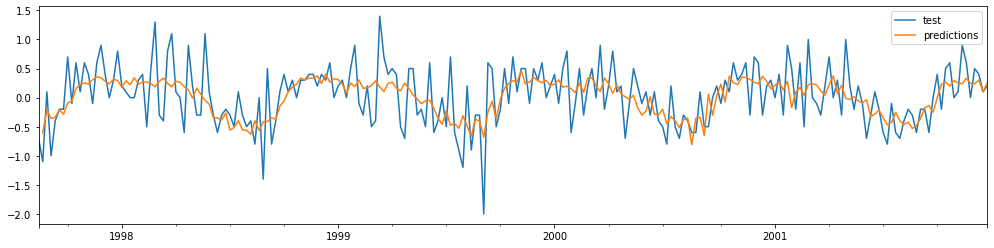

In [ ]:
fig, ax = plt.subplots(figsize=(17, 4))
data_test.plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();